In [2]:
import pandas as pd
import os, sys
from caseDetection import detect_case

ImportError: No module named rpy2.rinterface

In [2]:
df = pd.read_pickle("data/detected_case_all_Apr12.pkl")

In [10]:
df.head(1)

,ipids,ts,diff_list,retransmit_times,gIP,sIP,port,k1,k2,country,first_ts,diff_p1,diff_p2,domain,subcat,case,intervention,pvalue
138000,"[37236, None, 37241, 37244, 37246, 37247, 3725...","[60, 64, 70]","[1, None, None, 2, 1, 0, 3, 0, 4, 2, 0, 2, 1, ...","[0, 4, 10]",61.203.195.52,206.207.84.93,80,10,40,JP,60,48,60,bodybuilding.com,shopping,2,20.403612,2.483276e-78


## Sanitize by case
- remove case = 0, -1, 4
- case = -1 default: why??
- treat case -1 as 0 (did not enter else)

In [24]:
%load caseDetection.py

In [27]:
df_case_default = df[df['case'] == -1]
x = df_case_default.ix[138003,:]
print x


ipids               [59848, 59851, 59856, 59861, 59863, 59866, 598...
ts                                                       [60, 64, 70]
diff_list           [1, 2, 4, 4, 1, 2, 3, 1, 1, 1, 5, 3, 6, 2, 1, ...
retransmit_times                                           [0, 4, 10]
gIP                                                       59.53.57.86
sIP                                                     206.207.84.93
port                                                               80
k1                                                                 10
k2                                                                 40
country                                                            CN
first_ts                                                           60
diff_p1                                                            56
diff_p2                                                            56
domain                                               bodybuilding.com
subcat              

In [43]:
#!/usr/bin/env/ python
from intervention import *
import numpy as np
import random,glob
import string
import datetime as dt

INTERVENTION = 20 #number of forged packets
ALPHA = 0.01
ao_alpha = 0.05
diffList=[6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,10,10,11,9,9,8,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,10,13,9,9,9,9,None,None,10,9,9,9,9,9,9,None,None,9,9,9,None,None,None,9,9,None,None,9,9,10,9,9,9]
gIP="71.44.3.191"
sIP="198.211.105.99"
ts=[60,64,70]

def detect_case2(gIP,sIP,diffList,ts,error_case,INTERVENTION,DEBUG=False):

 #   if len(ts)<3: return(4,None,None)
 #   if error_case!=None: return(4,None,None)
    try:
        ir=intervention_at_time(diffList,ts, [0.5 * INTERVENTION,\
            (min(2,((len(ts)+1)/2))) * INTERVENTION], 0.05, True) #FIXME
        if DEBUG:print "ir.pvalues",ir.pvalues[0],ALPHA
        case =- 1
        #print ir.pvalues, ALPHA
        if ir.pvalues[0] <= ALPHA:
            case = 1
        elif ir.pvalues[0] > (1.0 - ALPHA):
            print ir.pvalues[1], (1.0 - ALPHA), ir.pvalues[1] < ALPHA, ir.pvalues[1] > (1.0 - ALPHA)
            if ir.pvalues[1] < ALPHA:
                case = 2
            elif ir.pvalues[1] > 1.0 - ALPHA:
                case = 3
        else:
            case = 0
        if DEBUG: print gIP,sIP,case,ir
        return(case,ir.pvalues[1],ir.intervention)
    except Exception:
        if DEBUG:print gIP,sIP, ts, "ERROR in detect case ARMA",diffList
        case = 4
        return(case,None,None)

#if __name__=="__main__":
#    print detect_case(gIP,sIP,diffList,ts,None,INTERVENTION,True)


In [44]:
detect_case2(x['gIP'],  x['sIP'], x['diff_list'], x['ts'], None, 20, True)

ir.pvalues 1.0 0.01
0.429390481471 0.99 False False
59.53.57.86 206.207.84.93 -1 order: (0, 0, 0)
removed additive outliers: [59, 119]
intervention: 39.907071
interventions: [39.618182, 39.451515, 39.907071]
null-interventions: [10.0, 40.0]
p-values: [1.000000, 0.429390]


(-1, 0.42939048147062264, 39.9070707070707)

In [101]:
df_bad = df [  df['case'].isin([0, -1, 4])  ]
df_good = df [  df['case'].isin([1,2,3])  ]

In [102]:
len(df_good)

197106

In [103]:
len(df_bad)

42703

In [104]:
# Save df_bad "bad_cases_detected" [sip, gip, country] 
df_bad[['sIP', 'gIP', 'country']].to_csv("data/case_er_redo")
df_bad.to_pickle("data/case_er_redo.pkl")

## Look at SIP and country
- due to measurement snafu same sIP and country pairs might have ran two or more measurements
- each of these measurements should usually end up in the same "case"
- but if two of these measurement have different "case" numbers => further analysis is needed
- only look at case 1,2,3

In [122]:
grouped_sIP_CO = df_good.groupby(["sIP", "country"])
df_sIP_CO = grouped_sIP_CO['case'].unique().reset_index()

In [124]:
df_sIP_CO["num_unique_cases"] = df_sIP_CO['case'].apply(lambda x: len(x))
df_redo = df_sIP_CO[df_sIP_CO['num_unique_cases'] > 1]
df_redo = df_redo.rename(columns={'case':'unique_cases'})
df_redo.head()

,sIP,country,unique_cases,num_unique_cases
7,1.209.122.23,BR,"[2, 1]",2
15,1.209.122.23,DE,"[2, 3]",2
20,1.209.122.23,FR,"[2, 1]",2
31,1.209.122.23,IT,"[2, 3]",2
32,1.209.122.23,JP,"[2, 1, 3]",3


In [125]:
# number of sIP challenged throughout
len(df_redo['sIP'].unique())

532

In [126]:
# number of countrie challenged throughout
len(df_redo['country'].unique())

63

In [109]:
# per country, how many unique sIPs
#df_temp = df_redo.groupby(['country'])['sIP'].count()
#df_temp.sort(ascending=False)
#df_temp

In [110]:
# per sIP, how many unique countries
#df_temp = df_redo.groupby(['sIP'])['country'].count()
#df_temp.sort(ascending=False)
#df_temp

### Flag these cases
- with sIP, country in df_redo
- further inversigation in df_good
- merge df_redo and df_good on ['sIP', 'country'] to get num_unique_cases
- expectedly from 63 x 532, all should have multiple cases

In [128]:
df_merged_unique_cases = df_good.merge(df_redo, on=['sIP', 'country'])

In [132]:
# which ones had just one result?

df_unique = df_merged_unique_cases[df_merged_unique_cases['num_unique_cases'] < 2]
print len(df_unique)
df_unique

0


,ipids,ts,diff_list,retransmit_times,gIP,sIP,port,k1,k2,country,first_ts,diff_p1,diff_p2,domain,subcat,case,intervention,pvalue,unique_cases,num_unique_cases


# DATA ANALYSIS
- per country num obs
- per country num unique sIPs tested

In [190]:
# meaningful num of countries
THRESHOLD = 350

In [191]:
# per country, how many unique sIPs
df_unique_sIP_per_country = df_good.groupby(['country'])['sIP'].unique().apply(lambda x:len(x))
df_current = df_unique_sIP_per_country[df_unique_sIP_per_country > THRESHOLD]


In [196]:
valid_countries = df_current.index
print valid_countries, len(valid_countries)

# filter df_good to only valid countries
# remove extra columns
df = df_good[  df_good['country'].isin(valid_countries)   ] [['sIP', 'gIP', 'country', 'diff_list', 'domain', 'subcat', 'case']]

Index([u'AR', u'AU', u'BR', u'CA', u'CN', u'CR', u'CZ', u'DE', u'DK', u'ES', u'FR', u'GB', u'ID', u'IN', u'IT', u'JP', u'KR', u'MX', u'MY', u'NL', u'NO', u'PH', u'PL', u'RU', u'SE', u'TH', u'TW', u'UA', u'US', u'ZA'], dtype='object') 30


In [197]:
df_obs_per_country = df.groupby('country').count().reset_index().sort('sIP', ascending=False)
# number of measurements per country
df_obs_per_country

,country,sIP,gIP,diff_list,domain,subcat,case
15,JP,29358,29358,29358,29358,29358,29358
28,US,27227,27227,27227,27226,27226,27227
16,KR,23992,23992,23992,23992,23992,23992
24,SE,17636,17636,17636,17636,17636,17636
10,FR,17108,17108,17108,17108,17108,17108
4,CN,14477,14477,14477,14477,14477,14477
7,DE,10447,10447,10447,10447,10447,10447
22,PL,7216,7216,7216,7216,7216,7216
2,BR,5178,5178,5178,5178,5178,5178
11,GB,3555,3555,3555,3555,3555,3555


In [198]:
# num of unique sIPs per country
df_unique_sIP_per_country = df.groupby('country')['sIP'].unique().apply(lambda x: len(x)).sort(inplace=False, ascending=False)
pd.DataFrame(df_unique_sIP_per_country).to_html('unique_sIP_per_country-filtered350.htm')

### case 1, 2, 3 per (country, subcat)

In [199]:
grouped_by_country_subcat_case = df.groupby(['country', 'subcat', 'case'])

In [200]:
count_per_country_subcat_case = grouped_by_country_subcat_case.count()

In [206]:
# replace nan with 0
df_case_count = count_per_country_subcat_case.unstack(level=-1)['sIP']
df_case_count['total'] = df_case_count.sum(axis=1)
df_case_count.to_html('cases_per_country_subcat-filtered350.htm')

case                      1     2    3  total
country subcat                               
AR      adult             5    51    6     62
        arts              4    47    2     53
        business        NaN    35  NaN     35
        circum          NaN    19    6     25
        computers         1    30   12     43
        games             1    22   11     34
        health            1    29    3     33
        home              1    38    6     45
        kids_and_teens    5    23    1     29
        news            NaN    22    4     26
        recreation        2    37    4     43
        reference         2    53    1     56
        regional          2    22    1     25
        science           3    52   12     67
        shopping        NaN    39    2     41
        society           2    49   11     62
        sports            2    31  NaN     33
        vpn             NaN    16    7     23
        world             4    47    6     57
AU      adult             3    46    5     54
        arts              2    60    2     64
        business        NaN    41  NaN     41
        circum          NaN    27    2     29
        computers         3    26   11     40
        games             7    33    8     48
        health            2    28    8     38
        home            NaN    26    1     27
        kids_and_teens  NaN    21  NaN     21
        news              2    23  NaN     25
        recreation        6    54    2     62
...                     ...   ...  ...    ...
US      kids_and_teens   27   741   64    832
        news             36   721  108    865
        recreation      243  1510  160   1913
        reference        25  1488  199   1712
        regional        137   654   48    839
        science          36  1726  360   2122
        shopping         28   849   78    955
        society          94  1414  533   2041
        sports          102   958   43   1103
        vpn               9   784  299   1092
        world            62  1434  214   1710
ZA      adult             1    43    9     53
        arts              3    57    3     63
        business          1    44  NaN     45
        circum          NaN    26    5     31
        computers       NaN    27    7     34
        games             2    34    6     42
        health            5    35    8     48
        home              5    31    1     37
        kids_and_teens    3    25    1     29
        news              1    18    5     24
        recreation        5    37    5     47
        reference         3    48  NaN     51
        regional          3    21  NaN     24
        science           4    48    4     56
        shopping          4    35    2     41
        society          13    46    8     67
        sports            3    31    3     37
        vpn             NaN    28    8     36
        world             4    46    5     55

[570 rows x 4 columns]

#### Censorship by country for each subcat
- create num(subcat) bar plots comparing case2 with (case1 + case3)

In [215]:
# clear all except df_case_count
del df, df_bad, df_case_default, df_current, df_good, df_merged_unique_cases, df_obs_per_country, df_redo
del df_sIP_CO, df_temp, df_unique, df_unique_sIP_per_country

In [216]:
group_by_subcat = df_case_count.reset_index().groupby('subcat')

In [227]:
subcat = 'adult'
temp_df = df_case_count.ix[ group_by_subcat.groups[subcat] ].reset_index()
temp_df['censored'] = temp_df[1]+temp_df[3]
temp_df = temp_df.rename(columns={2:'uncensored'})[['country', 'censored', 'uncensored']].set_index('country')

In [235]:
temp_df

case,censored,uncensored
country,,
AR,11,51
AU,8,46
BR,60,265
CA,38,144
CN,274,775
CR,19,56
CZ,16,59
DE,137,633
DK,9,77


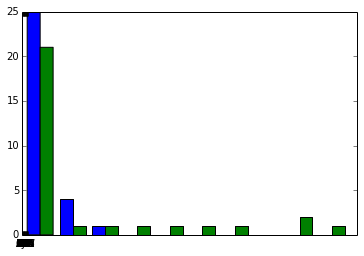

In [243]:
fig1, ax1 = subplots(1,1)
ax1.hist((temp_df['censored'], temp_df['uncensored']))
ax1.set_xticks(range(len(temp_df)))

#labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = temp_df.index

ax1.set_xticklabels(labels)